In [189]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [190]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [191]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [192]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [193]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [194]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [195]:
#new_distance = lambda den,dist: den/dist

In [196]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [197]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [198]:
year = '2018'

### Get initial point with most density of biomass

In [199]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [200]:
k=10

In [201]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [202]:
weights=set_prob_depots(biomass_density[year])

In [203]:
def get_depots(k,year,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[year].shape[0],size=k,p=weights)
    return list(depots)

In [204]:
biomass_density[year].shape[0]

2418

In [205]:
depots = get_depots(k,year,weights)

### Visualising Data

In [206]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

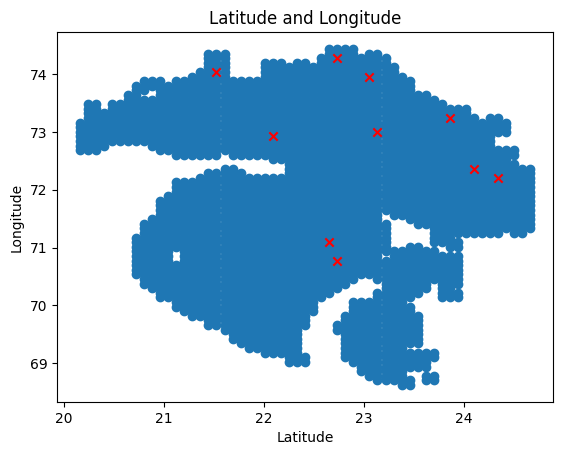

In [207]:
plot_depots(depots)

## Optimal clusters for depots

In [208]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        if len(X[belonging_to_cluster==i][['Latitude','Longitude']]) != 0:
            pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
            depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        else:
            depots = get_depots(k,year,weights)
            re_cluster_depots(k,X,depots)
        
    return depots,belonging_to_cluster

In [209]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1191, 960, 97, 1716, 819, 1528, 262, 1255, 2192, 312]
[1304, 896, 144, 1664, 944, 1702, 261, 1194, 2266, 272]
[1369, 896, 367, 1664, 941, 1861, 261, 1387, 2266, 312]
[1434, 895, 591, 1664, 1001, 1918, 177, 1510, 2266, 311]
[1433, 895, 590, 1664, 1000, 1918, 149, 1510, 2266, 310]
[1493, 895, 589, 1663, 999, 1975, 149, 1510, 2266, 309]
[1493, 895, 650, 1663, 1053, 1975, 147, 1510, 2266, 350]
[1493, 895, 649, 1604, 1106, 2030, 172, 1510, 2266, 350]
[1493, 895, 649, 1603, 1105, 2029, 172, 1510, 2266, 350]
[1493, 895, 648, 1603, 1105, 2029, 172, 1510, 2266, 350]
Convergence in : 10 iterations


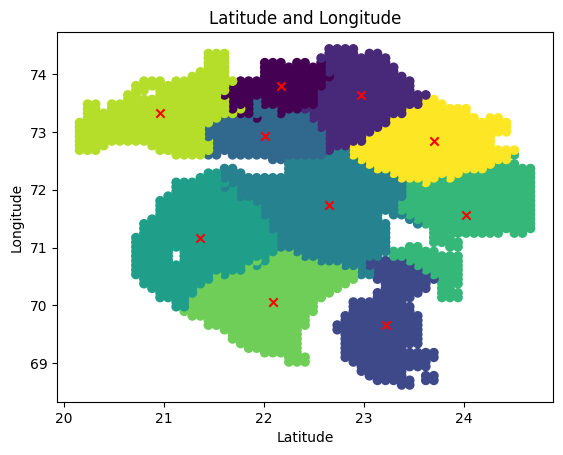

In [210]:
plot_depots(depots,clusters)

## Finding refineries

In [211]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,0.180534,0.180260,0.170496,0.129193,0.180347,0.190154,0.231986,0.181932,0.177813,0.534950
2414,20.15456,72.92394,0.051700,0.054713,0.048782,0.044817,0.051860,0.054145,0.065674,0.051462,0.048789,0.564789
2415,20.15456,73.00357,0.035414,0.037422,0.033379,0.030625,0.035525,0.037108,0.044995,0.035245,0.034098,0.564997
2416,20.15456,73.08319,0.145447,0.121111,0.097915,0.099246,0.114721,0.119751,0.145269,0.113851,0.120770,0.528472


In [255]:
def biomass_per_depot(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
        #print(biomass)
    return biomass

In [213]:
biomass_per_depot=biomass_per_depot(k,clusters,year)
biomass_per_depot

[45.43392868499999,
 82.85774003699997,
 55.41135106530001,
 80.669769001,
 219.25925231399987,
 202.39857159799996,
 111.43716380800002,
 168.31231169100008,
 94.33371920400003,
 114.77983774000008]

In [214]:
depots

[1493, 895, 648, 1603, 1105, 2029, 172, 1510, 2266, 350]

In [215]:
r=5

In [216]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [217]:
biomass_per_depot

[45.43392868499999,
 82.85774003699997,
 55.41135106530001,
 80.669769001,
 219.25925231399987,
 202.39857159799996,
 111.43716380800002,
 168.31231169100008,
 94.33371920400003,
 114.77983774000008]

In [218]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.03867067361612844,
 0.07052360899176872,
 0.0471628655873286,
 0.0686613374193209,
 0.1866205109035696,
 0.17226969643989665,
 0.09484872462171517,
 0.14325748750685538,
 0.08029128389105747,
 0.097693811022359]

In [219]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    print(refineries_index)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [220]:
get_refineries(5,depots,weights)

[8 4 5 5 7]


[2266, 1105, 2029, 2029, 1510]

In [221]:
refineries = get_refineries(r,depots,weights)
refineries

[9 2 6 6 2]


[350, 648, 172, 172, 648]

## Optimal clusters for refineries

In [222]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
        
    X=np.array(X)
    refineries = []
    for i in range(r):
        if len(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy()) != 0:
            pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(), axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
            refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
        else:
            refineries = get_refineries(r,depots,weights)
            re_cluster_refineries(r,X,refineries)
    return refineries,belonging_to_cluster

In [223]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

[4 0 4 6 5]
[0 8 8 4 3]
[6 9 2 7 7]
[7 5 6 9 3]
[7 2 5 0 9]
[1510, 648, 2029, 1493, 350]
[1510, 648, 1588, 1609, 260]
Convergence in : 2 iterations


In [224]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [225]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

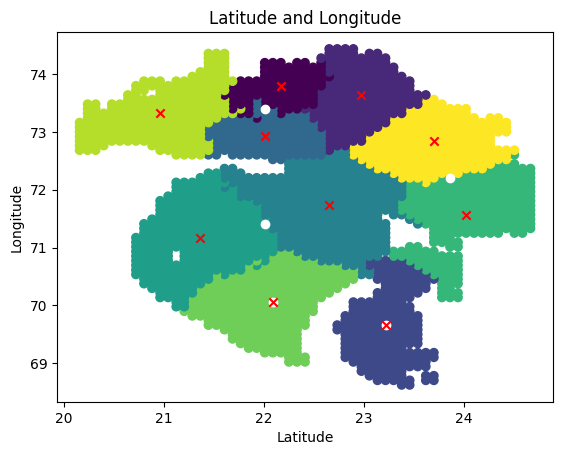

In [226]:
plot_depots(depots,clusters,refineries)

## Loss function for depots

In [227]:
biomass_per_depot

[45.43392868499999,
 82.85774003699997,
 55.41135106530001,
 80.669769001,
 219.25925231399987,
 202.39857159799996,
 111.43716380800002,
 168.31231169100008,
 94.33371920400003,
 114.77983774000008]

In [228]:
biomass_per_refinery

[168.31231169100008,
 55.41135106530001,
 421.6578239119998,
 303.295156927,
 226.2170015480001]

In [229]:
clusters

array([6., 6., 6., ..., 8., 8., 8.])

In [230]:
cluster_depots

array([3., 3., 1., 3., 2., 2., 4., 0., 3., 4.])

In [231]:
depots

[1493, 895, 648, 1603, 1105, 2029, 172, 1510, 2266, 350]

In [232]:
refineries

[1510, 648, 1588, 1609, 260]

In [233]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum([biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index]))
    #print(loss)
    return sum(loss)

In [234]:
def loss_refinery(refineries,cluster_depots,depots):
    loss=[]
    refineries=np.array(refineries)
    depots = np.array(depots)
    for i in range(len(refineries)):
        loss.append(sum([biomass_per_depot[x]*distance_matrix.iloc[depots[x],refineries[i]] for x in np.where(depots[cluster_depots==i])[0]]))
    #print(loss)
    return sum(loss)

In [235]:
loss_depot(depots,year)

90138.7520851664

In [236]:
loss_refinery(refineries,cluster_depots,depots)

169197.61541931212

### Optimal number for depots

In [237]:
k=range(1,25)

Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 4 iterations
Convergence in : 13 iterations
Convergence in : 12 iterations
Convergence in : 13 iterations
Convergence in : 8 iterations
Convergence in : 6 iterations
Convergence in : 30 iterations
Convergence in : 12 iterations
Convergence in : 10 iterations
Convergence in : 8 iterations
Convergence in : 15 iterations
Convergence in : 20 iterations
Convergence in : 10 iterations
Convergence in : 11 iterations
Convergence in : 11 iterations
Convergence in : 10 iterations
Convergence in : 10 iterations
Convergence in : 20 iterations
Convergence in : 10 iterations
Convergence in : 14 iterations
Convergence in : 18 iterations
Convergence in : 30 iterations


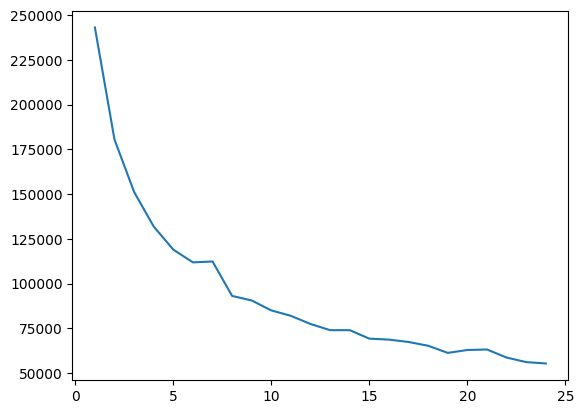

In [238]:
loss_d=[]
for i in k:
    year = '2018'
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

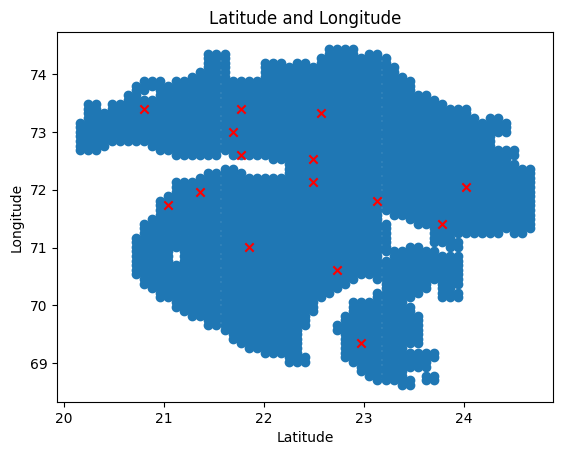

In [239]:
num_of_depots = 15
weights = set_prob_depots(density=biomass_density[year])
depots = get_depots(num_of_depots,year,weights)
plot_depots(depots)

In [240]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(num_of_depots,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[645, 1836, 1220, 1927, 1936, 2344, 2250, 1800, 1063, 246, 1020, 1142, 1600, 182, 807]
[646, 1837, 1276, 1869, 1994, 2344, 2210, 1798, 1009, 246, 959, 1256, 1543, 183, 805]
[646, 1838, 1341, 1868, 1994, 2344, 2209, 1850, 947, 246, 960, 1255, 1544, 183, 803]
[646, 1890, 1341, 1925, 1994, 2357, 2209, 1907, 946, 246, 960, 1386, 1485, 184, 866]
[646, 1947, 1407, 1925, 1994, 2357, 2209, 1907, 883, 206, 960, 1448, 1486, 184, 865]
[646, 2004, 1407, 1982, 1994, 2357, 2209, 1908, 817, 206, 897, 1447, 1487, 184, 927]
[646, 2058, 1407, 1982, 1994, 2356, 2210, 1908, 817, 247, 897, 1447, 1428, 158, 926]
[646, 2058, 1407, 1982, 1937, 2367, 2209, 1908, 817, 247, 898, 1446, 1428, 157, 926]
[646, 2058, 1407, 1982, 1937, 2367, 2210, 1851, 818, 247, 898, 1446, 1429, 157, 987]
[646, 2058, 1407, 1982, 1937, 2367, 2209, 1851, 751, 247, 898, 1446, 1429, 157, 987]
[646, 2058, 1407, 1982, 1937, 2367, 2209, 1851, 751, 206, 897, 1446, 1429, 157, 987]
[646, 2058, 1407, 1982, 1937, 2367, 2209, 1851, 751, 246, 898,

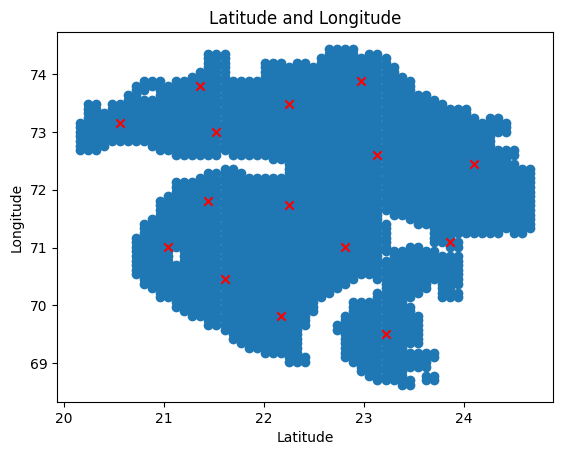

In [243]:
plot_depots(depots)

### Optimal Number of refineries

In [261]:
k = range(1,5)

In [262]:
loss_d=[]
for i in k:
    year = '2018'
    biomass_per_depot=biomass_per_depot(i,clusters,year)
    weights = set_prob_ref(biomass_per_depot)
    print(weights)
    refineries = get_refineries(i,depots,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters = re_cluster_refineries(i,depots,refineries)
        if np.array_equal(prev,refineries):
            break
        print(refineries)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

TypeError: 'list' object is not callable

In [260]:
biomass_per_depot(3,clusters,'2018')

TypeError: 'list' object is not callable

In [250]:
sum(biomass_density[clusters==1]['2018'])

26.354971600000002